1.1 (Cleaning the dataset by removing invalid grades, forcing the correct date format, and removing duplicate inspections) 

In [35]:
import pandas as pd

# 1. Load the joined data
df = pd.read_csv("nyc_yelp_joined_v2.csv")
print(df)

# 2. Parse inspection date
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION DATE"], errors="coerce") #If date is invalid, it will replace with "NaT"

# 3. Drop duplicated inspections (same restaurant + date)
df = df.sort_values("INSPECTION_DATE").drop_duplicates(
    ["CAMIS", "INSPECTION DATE"], keep="first"
)

         CAMIS                         DBA       BORO BUILDING  \
0     50118276                    iPizzaNY  Manhattan      658   
1     50160867           TOKA CHEF KITCHEN  Manhattan      201   
2     50144218              KAZUMI OMAKASE  Manhattan       31   
3     50168216            TAQUERIA CONDESA  Manhattan      824   
4     50163886                    VERDELLO  Manhattan      994   
...        ...                         ...        ...      ...   
1551  50174334          PANKS BROADWAY INC  Manhattan     1450   
1552  50168691  MIZNON AT HUDSON YARDS LLC  Manhattan       20   
1553  50168691  MIZNON AT HUDSON YARDS LLC  Manhattan       20   
1554  50170550   EATALY CAFFE HUDSON YARDS  Manhattan       20   
1555  50170550   EATALY CAFFE HUDSON YARDS  Manhattan       20   

                STREET  ZIPCODE       PHONE CUISINE DESCRIPTION  \
0             9 AVENUE    10036  9176757587               Pizza   
1         ALLEN STREET    10002  3474592184                 NaN   
2     

1.2 (Creates prediction labels) 

In [36]:
#A, B, C are Standard Grades. N and Z is grade Pending. P is not yet graded. 

# 4. Keep inspections with a real grade
valid_grades = ["A", "B", "C", "N", "Z", "P"]
df = df[df["GRADE"].isin(valid_grades)].copy()

# 5. Binary label: 1 = high risk, 0 = low risk
#going to create a row. Restuarant with grade A is low risk. Restuarants with grade b, c, n, z, p are high risk
df["high_risk"] = (df["GRADE"] != "A").astype(int)

print(df)

         CAMIS                           DBA       BORO BUILDING  \
70    41414060              EL PASO TAQUERIA  Manhattan     1643   
1532  50071438           PLAYSTATION THEATRE  Manhattan     1515   
1478  40761262  CIRCLE IN THE SQUARE THEATRE  Manhattan     1633   
1493  40750343                   VIEW LOUNGE  Manhattan     1535   
1503  40983698         YUCA BAR & RESTAURANT  Manhattan      111   
...        ...                           ...        ...      ...   
239   50131548                 SPICY VILLAGE  Manhattan       68   
1379  40400453               CAFE EIGHTY TWO  Manhattan     2282   
964   50142447                     SUSHI SHO  Manhattan        3   
699   41636015             BOBWHITE COUNTER.  Manhattan       94   
1001  50051304                      MOMOKAWA  Manhattan     1466   

                STREET  ZIPCODE       PHONE CUISINE DESCRIPTION  \
70    LEXINGTON AVENUE    10029  2128319831             Mexican   
1532          BROADWAY    10036  2129301950      

1.3 (Select features)
Numerical features: "Yelp Star Rating", "Review Count" 
Categorical features: "Borough", "Cuisine type", "Yelp Price level" 

In [37]:

feature_cols_num = ["rating", "review_count"]
feature_cols_cat = ["BORO", "CUISINE DESCRIPTION", "price"]
text_col = "categories"

X = df[feature_cols_num + feature_cols_cat + [text_col]]
y = df["high_risk"]
#prepares DataFrame for machine learning. 
print(X) #X = full feature matrix
print(y) #y = prediction target (high risk or not) 

      rating  review_count       BORO CUISINE DESCRIPTION price  \
70       3.2           290  Manhattan             Mexican    $$   
1532     4.0          6710  Manhattan            American    $$   
1478     4.4            46  Manhattan            American    $$   
1493     4.4            75  Manhattan            American   NaN   
1503     4.0          2204  Manhattan      Latin American    $$   
...      ...           ...        ...                 ...   ...   
239      4.2           912  Manhattan             Chinese    $$   
1379     3.4           215  Manhattan            American    $$   
964      4.8            19  Manhattan            Japanese   NaN   
699      4.3           984  Manhattan           Soul Food    $$   
1001     4.1           270  Manhattan            Japanese   $$$   

                                          categories  
70                                           Mexican  
1532           Bakeries, Breakfast & Brunch, Burgers  
1478  Patisserie/Cake Shop, Sa

1.4 (Splits the dataset by YEAR) 
- Train: <= 2021
- Validation: 2023
- Test: 2024

In [38]:
df["year"] = df["INSPECTION_DATE"].dt.year

train_mask = df["year"] <= 2023
val_mask   = df["year"] == 2024
test_mask  = df["year"] >= 2025

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

#Showing the first few rows
print("X_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

print("X_val:", X_val.head())
print("y_val:", y_val.head())

print("X_test:", X_test.head())
print("y_test:", y_test.head())

#Used to show if the split worked
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

print(df["year"].value_counts().sort_index())


X_train:
      rating  review_count       BORO CUISINE DESCRIPTION price  \
70       3.2           290  Manhattan             Mexican    $$   
1532     4.0          6710  Manhattan            American    $$   
1478     4.4            46  Manhattan            American    $$   
1493     4.4            75  Manhattan            American   NaN   
1503     4.0          2204  Manhattan      Latin American    $$   

                                          categories  
70                                           Mexican  
1532           Bakeries, Breakfast & Brunch, Burgers  
1478  Patisserie/Cake Shop, Sandwiches, Coffee & Tea  
1493                Lounges, American, Cocktail Bars  
1503       Latin American, Tapas Bars, Cocktail Bars  

y_train:
70      0
1532    0
1478    0
1493    0
1503    0
Name: high_risk, dtype: int64
X_val:       rating  review_count       BORO CUISINE DESCRIPTION price  \
86       4.4          1106  Manhattan             Chinese   $$$   
1189     4.9            92 

#2.1 Pipeline that 
1. Automatically preprocesses mixed data types
- numeric -> StandardScaler
- categorical -> OneHotEncoder
- text -> CountVectorizer
2. Trains a logistic regression classifier
3. Fits the full pipeline on training data

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

numeric_features = feature_cols_num
categorical_features = feature_cols_cat
text_feature = text_col

# 1. Preprocessing for each feature type
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("cat_text", CountVectorizer(max_features=50), text_feature),
    ]
)



#Takes in the numeric column

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess), #preprocessing is ColumnTransformer, which means it treats each column differently
        ("clf", RandomForestClassifier(
            n_estimators=300, #300 trees. More trees for stable model. 
            max_depth=None, #Unlimited depth
            min_samples_split=10, #helps to prevent overfitting
            n_jobs=-1,
            class_weight="balanced_subsample",
            random_state=42
        ))
    ]
)

print(rf_clf.fit(X_train, y_train))
feature_names = rf_clf.named_steps["preprocess"].get_feature_names_out()
print("Number of final features:", len(feature_names))
print("Sample of feature names:", feature_names[:30])

rf = rf_clf.named_steps["clf"]
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 20 most important features:")
print(feat_imp.head(20))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['rating', 'review_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BORO',
                                                   'CUISINE DESCRIPTION',
                                                   'price']),
                                                 ('cat_text',
                                                  CountVectorizer(max_features=50),
                                                  'categories')])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=42))])
Number of

In [40]:
print("\nAverage Yelp rating by risk label:")
print(df.groupby("high_risk")["rating"].mean())

print("\nAverage review count by risk label:")
print(df.groupby("high_risk")["review_count"].mean())



Average Yelp rating by risk label:
high_risk
0    4.177316
1    4.168063
Name: rating, dtype: float64

Average review count by risk label:
high_risk
0    495.690096
1    458.345550
Name: review_count, dtype: float64


#2.2 Random forest 
- forest wraped inside a calibration model
- fits an isotonic regression on validation data
- Produces well-calibrated probabilities for your final predictions

In [41]:
from sklearn.calibration import CalibratedClassifierCV

# Fit RF on train only
rf_clf.fit(X_train, y_train)

# Calibrate probabilities on validation set (Platt / isotonic). Needed since raw random forest probabilities are overconfident, not monotonic, and poorly aligned with reality
calibrated_rf = CalibratedClassifierCV(
    estimator=rf_clf,    # <--- changed here
    method="isotonic",   # or "sigmoid" for Platt scaling
    cv="prefit"          # tells sklearn rf_clf is already fitted
)

print(calibrated_rf.fit(X_val, y_val))


/usr/local/venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['rating',
                                                                                    'review_count']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['BORO',
                                                                                    'CUISINE '
                                                                                    'DESCRIPTION',
              

#2.3 Threshold tuning + final evaluation 
- precision_recall_curve will give you precision/recall for many thresholds so you can pick a good cutoff

In [42]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Predict calibrated probabilities on validation set
val_probs = calibrated_rf.predict_proba(X_val)[:, 1]  # P(high_risk)

precision, recall, thresholds = precision_recall_curve(y_val, val_probs)

target_recall = 0.9  # you can also try 0.85

# Indices where recall is at least target
valid_idx = np.where(recall >= target_recall)[0]

if len(valid_idx) > 0:
    # Among those, pick threshold with highest precision
    best_idx = valid_idx[np.argmax(precision[valid_idx])]
    best_threshold = thresholds[best_idx]
else:
    # Fallback if you never reach target recall
    best_threshold = 0.5


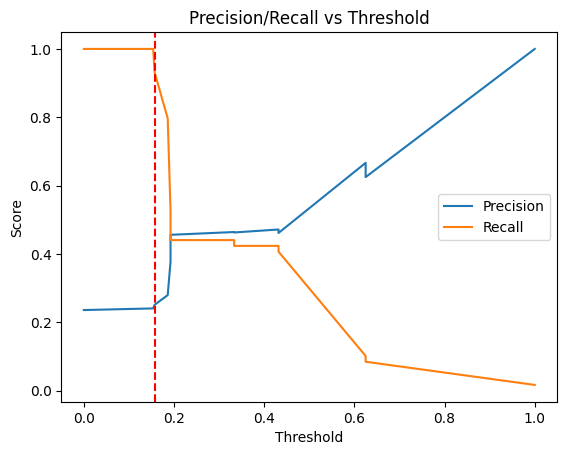

In [43]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_threshold, color='red', linestyle='--')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision/Recall vs Threshold")
plt.show()

#2.4 Standard metrics. 
1. Classification report 
- precision / recall / f1 / support for
- class 0 (low risk)
- class 1 (high risk)
- overall accuracy, marco average, weighted average
2. AUROC (Area Under ROC Curve)
- Threshold-independent measure of ranking quality
3. AUPRC (Average Precision)
  - Area under precision-recall curve.
4. Confusion Matrix


In [44]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)

# 1. Probabilities and hard predictions
test_probs = calibrated_rf.predict_proba(X_test)[:, 1]
test_pred = (test_probs >= best_threshold).astype(int)

# 2. Standard metrics
print(classification_report(y_test, test_pred, digits=3))
print("AUROC: ", roc_auc_score(y_test, test_probs))
print("AUPRC: ", average_precision_score(y_test, test_probs))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))


              precision    recall  f1-score   support

           0      0.763     0.141     0.239       205
           1      0.307     0.897     0.457        87

    accuracy                          0.366       292
   macro avg      0.535     0.519     0.348       292
weighted avg      0.627     0.366     0.304       292

AUROC:  0.6016260162601627
AUPRC:  0.3810924047417326
Confusion matrix:
 [[ 29 176]
 [  9  78]]


#2.5 Rank restuarants and compute "top 10% captur3e rate" 

In [45]:
import numpy as np

# Sort test restaurants by predicted probability (descending)
test_df = df[test_mask].copy()
test_df["prob_high_risk"] = test_probs
test_df["y_true"] = y_test.values

test_df = test_df.sort_values("prob_high_risk", ascending=False)

# Top 10% most risky
k = int(0.10 * len(test_df))
top_k = test_df.head(k)

# Share of all high-risk restaurants captured in that top 10%
total_high_risk = (test_df["y_true"] == 1).sum()
captured_high_risk = (top_k["y_true"] == 1).sum()

capture_rate = captured_high_risk / total_high_risk if total_high_risk > 0 else 0
print(f"Top 10% capture rate: {capture_rate:.3f}")


Top 10% capture rate: 0.161


In [46]:
from sklearn.metrics import recall_score

def group_recall(df_group):
    return recall_score(df_group["y_true"], df_group["y_pred"])

test_df["y_pred"] = test_pred

borough_recalls = test_df.groupby("BORO").apply(group_recall)
print(borough_recalls)
#So 97% of the bad restuarants in NYC are found

BORO
Manhattan    0.83908
dtype: float64


/tmp/ipykernel_2128099/1109270218.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  borough_recalls = test_df.groupby("BORO").apply(group_recall)
